In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, fbeta_score
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
sns.set()
%matplotlib inline 

## Data Wrangling

### Coleta
1. Loop entre os arquivos
2. Salva arquivo em um DataFrame
3. Concatena o DatFrame com o anterior

In [2]:
# Data da extração dos dados: 27/11/2018

import os
input_folder = '../input/'
flag_first = True
#O campo ano não será utilizado pois a ideia é utilizar o modelo para diversos anos tendo como base os dois anos aqui analisados
years = ['2016','2017']

for y in years:
    for i in os.listdir('../input/' + y):
        filepath = input_folder + '/' + y + '/' + i
        if 'csv' in i:
            if flag_first:
                df = pd.read_csv(filepath, low_memory=False)
                flag_first = False
                #df['ANO'] = y
            else:
                df_aux = pd.read_csv(filepath, low_memory=False)
                #df_aux['ANO'] = y
                df = pd.concat((df, df_aux))

# Arquivo com a quantidade de debitos de cada contribuinte. Os dados do contribuinte foram apagados,
# porém suas respectivas quantidades foram adicionadas a cada débito
count_debitos = pd.read_csv(input_folder + 'quantidade_debitos.csv')

count_debitos.drop(['perc_debitos_pagos'], axis=1, inplace=True)
df.drop(['IND_DEB_TRBR'], axis=1,inplace=True)
    
df.info()

C:\Users\uaqui\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<class 'pandas.core.frame.DataFrame'>
Int64Index: 3338995 entries, 0 to 299780
Data columns (total 14 columns):
COD_DEB               int64
COD_SSIS_ORIG         object
COD_TIP_ATLZ_DEB      object
DESC_TIP_CTBU_ORIG    object
DESC_TIP_DEB          object
DESC_TIP_LANC         object
DT_ATLZ_TAB           object
DT_EXCL_DEB           object
DT_INCL_DEB           object
MES                   int64
VAL_JURO_MRA          object
VAL_MLTA_MRA          object
VAL_MLTA_PUNI         int64
VAL_PRIN_DEB          object
dtypes: int64(3), object(11)
memory usage: 382.1+ MB


## Limpeza

1. **Remoção de registros:**
    1. Remover os debitos que não possuem nenhum contribuinte associado (sujeira da base de dados do nosso cadastro)
        1. o arquivo quantidade_debitos só possui debitos com contribuintes associados;
        2. Basta fazer um inner join para eliminar os registros "sujos"
    2. Remover débitos de contribuintes não tributários:
        1. Não são competência da SEFAZ cobrar.
    3. Remover débitos inscritos em dívida ativa
        1. Débitos cujo o tipo de Lançamento incluem "RDT";
        2. Débitos negados que possuem juros e multa
        3. Necessário garantir que os campos são númericos antes da verificação
    4. Remover os débitos do parcelamento
        1. são os débitos pertencentes ao sistema PAT/PPI

2. **Formatando:**
    1. Campos de data
    2. Campos de categoria

3. ** Engenharia de Características: **
    1. Obtendo o campo dias_ate_pagar
    2. Obtendo a variável alvo (target)
    
4. ** Valores inconsistentes: **
    1. Nomes diferentes que querem dizer a mesma coisa
    
5. ** Exclusão de colunas desnecessárias **

In [3]:
# Passo 1A
df_clean = df.merge(count_debitos, how='inner', on='COD_DEB')

# Passo 1B
df_clean = df_clean[~(df_clean.DESC_TIP_CTBU_ORIG == 'Contribuinte não tributários')]

# Passo 1C

# Garantindo que os campos são númericos
numeric_fields = ['VAL_JURO_MRA', 'VAL_MLTA_MRA', 'VAL_PRIN_DEB', 'VAL_MLTA_PUNI',
                  'debitos_contribuinte']
for i in numeric_fields:
    try:
        df_clean[i] = df_clean[i].str.replace(',', '.')
    except AttributeError:
        pass
    df_clean[i] = df_clean[i].astype(float)

    
#Eliminando os inscritos em dívida ativa
df_clean = df_clean[~df_clean.DESC_TIP_LANC.str.contains('RDT')]
df_clean = df_clean[~df_clean.DESC_TIP_DEB.str.contains('Ativa')]
df_clean = df_clean[~((df_clean.VAL_MLTA_MRA > 0) & ( df_clean.COD_TIP_ATLZ_DEB == 'N'))]

# Passo 1D
df_clean = df_clean[~(df_clean.COD_SSIS_ORIG == 'PAT')]

# Quantidade de débitos removidos:
removidos = df.shape[0] - df_clean.shape[0]
print('Quantidade de débitos removidos: {}'.format(removidos))
print('Porcentagem do total: {} %'.format(round(100*removidos/df.shape[0], 2)))

Quantidade de débitos removidos: 738988
Porcentagem do total: 22.13 %


In [4]:
# Passo 2A
date_fields = ['DT_ATLZ_TAB', 'DT_EXCL_DEB', 'DT_INCL_DEB']
for i in date_fields:
    df_clean[i] = pd.to_datetime(df_clean[i])

In [5]:
# Passo 2B
cat_fields = ['MES', 'COD_TIP_ATLZ_DEB', 'DESC_TIP_LANC', 'DESC_TIP_DEB',
             'COD_SSIS_ORIG', 'DESC_TIP_CTBU_ORIG', 'COD_DEB']
for i in cat_fields:
    df_clean[i] = df_clean[i].astype('category')

1. Quando a data de Exclusão do débito é menor que a inclusão, é porque o débito ainda não foi excluído
    2. Atualizar a data de exclusão para esses casos para a data atual
2. Criar um campo dias_ate_pagar = Exclusão do débito - Inclusão do Débito
3. O Campo DT_ATLZ_TAB perde o sentido pois todo débito pago é atualizado. Logo, quando pago DT_ATLZ == DT_EXCL

In [6]:
# Passo 3A
# dias_ate_pagar = data de exclusão - data de inclusão
# quando o débito ainda não foi pago, data de exclusão = today()
df_clean.loc[df_clean.DT_INCL_DEB > df_clean.DT_EXCL_DEB, 'DT_EXCL_DEB'] = pd.Timestamp.today()
df_clean['dias_ate_pagar'] = (df_clean.DT_EXCL_DEB - df_clean.DT_INCL_DEB).dt.days
df_clean['dias_ate_pagar'] = df_clean['dias_ate_pagar'].astype(float)

##### Obtendo a variável alvo

1. ** O Campo COD_ATLZ_DEB possui três valores: **
    1. I: débito incluido no rol de dividas
    2. A: débito atualizado (alguma multa ou movimentação)
    3. N: débito negado (foi pago ou inscrito em dívida ativa.)
        1. Os débitos negados que possuem multa e juros calculados são aqueles inscritos em dívida ativa;
        2. a fazenda não pode cobrar esses débitos. Uma vez inscritos em dívida ativa, cabe à procuradoria do município cobrar;
        3. Esses débitos serão excluídos da amostra
2. ** Objetivo: **
    1. Serão excluídos os debitos com dias_ate_pagar < 30, este são débitos saudáveis que não exigem esforço da cobrança
    2. Débitos pagos no intervalo 30 a 180 serão classificados como Cobráveis
    3. Os demais como Não Cobráveis

In [7]:
# Passo 3B
df_clean = df_clean[df_clean.dias_ate_pagar > 30].copy()
df_clean['target'] = 'Não Cobrável'
df_clean.loc[(df_clean.COD_TIP_ATLZ_DEB == 'N') & (df_clean.dias_ate_pagar <= 360), 'target'] = 'Cobrável'
df_clean['target'] = df_clean['target'].astype('category')

In [8]:
# Passo 4a
df_clean['DESC_TIP_DEB'] = df_clean['DESC_TIP_DEB'].astype(str)
#TFF
df_clean.loc[df_clean.DESC_TIP_DEB == 'Taxa de Fiscalização do Funcionamento', 'DESC_TIP_DEB'] = 'TFF'
df_clean.loc[df_clean.DESC_TIP_DEB == 'TAXA DE FISCALIZAÇÃO DE FUNCIONAMENTO', 'DESC_TIP_DEB'] = 'TFF'

#ISS
df_clean.loc[df_clean.DESC_TIP_DEB == 'Imposto sobre Serviços', 'DESC_TIP_DEB'] = 'ISS'
df_clean.loc[df_clean.DESC_TIP_DEB == 'IMPOSTO SOBRE SERVICOS', 'DESC_TIP_DEB'] = 'ISS'
df_clean.loc[df_clean.DESC_TIP_DEB == 'Imposto sobre Serviço de Qualquer Natureza (Confissão de Débito)', 'DESC_TIP_DEB'] = 'ISS (confissão de débito)'

#IPTU
df_clean.loc[df_clean.DESC_TIP_DEB == 'Imposto Predial Territorial Urbano', 'DESC_TIP_DEB'] = 'IPTU'
df_clean.loc[df_clean.DESC_TIP_DEB == 'IMPOSTO PREDIAL E TERRITORIAL URBANO', 'DESC_TIP_DEB'] = 'IPTU'

#TRSD
df_clean.loc[df_clean.DESC_TIP_DEB == 'Taxa de Limpeza Pública', 'DESC_TIP_DEB'] = 'TRSD'

df_clean['DESC_TIP_DEB'] = df_clean['DESC_TIP_DEB'].astype('category')

In [9]:
# Passo 5
df_clean['PRINCIPAL'] = 0
for i in numeric_fields:
    df_clean[i].fillna(0, inplace=True)
    df_clean['PRINCIPAL'] = df_clean['PRINCIPAL'] + df_clean[i]


df_clean.drop(['DT_ATLZ_TAB', 'DT_EXCL_DEB', 'DT_INCL_DEB',
              'VAL_JURO_MRA', 'VAL_MLTA_MRA', 'VAL_MLTA_PUNI',
               'VAL_PRIN_DEB'], axis=1, inplace=True)

In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2020169 entries, 13 to 2739772
Data columns (total 11 columns):
COD_DEB                 category
COD_SSIS_ORIG           category
COD_TIP_ATLZ_DEB        category
DESC_TIP_CTBU_ORIG      category
DESC_TIP_DEB            category
DESC_TIP_LANC           category
MES                     category
debitos_contribuinte    float64
dias_ate_pagar          float64
target                  category
PRINCIPAL               float64
dtypes: category(8), float64(3)
memory usage: 182.7 MB


## Análise

1. ** Proporção dos débitos cobráveis **
2. ** Distribuição das variáveis númericas **
    1. Tratando Outliers    
3. ** Relação das Variáveis categóricas com a variável dependente **


In [11]:
# Verificando as proporções da target
# O valor está maior do que o que consta na proposta do projeto, pois a limpeza acabou removendo registros
print('proporção de pagas / total: {}'.format(round(df_clean[df_clean.target == 'Cobrável'].shape[0] / df_clean.shape[0], 3)))

proporção de pagas / total: 0.351


### Distribuição das variáveis númericas

In [12]:
df_clean.describe()

,debitos_contribuinte,dias_ate_pagar,PRINCIPAL
count,2.020169e+06,2.020169e+06,2.020169e+06
mean,1.329223e+01,4.382954e+02,1.397418e+03
std,4.790477e+01,3.376910e+02,1.426393e+05
min,1.000000e+00,3.100000e+01,1.010000e+00
25%,4.000000e+00,7.800000e+01,4.252000e+01
50%,6.000000e+00,4.680000e+02,8.738000e+01
75%,1.400000e+01,6.790000e+02,2.777700e+02
max,1.003000e+03,1.648000e+03,1.270831e+08


### Principal

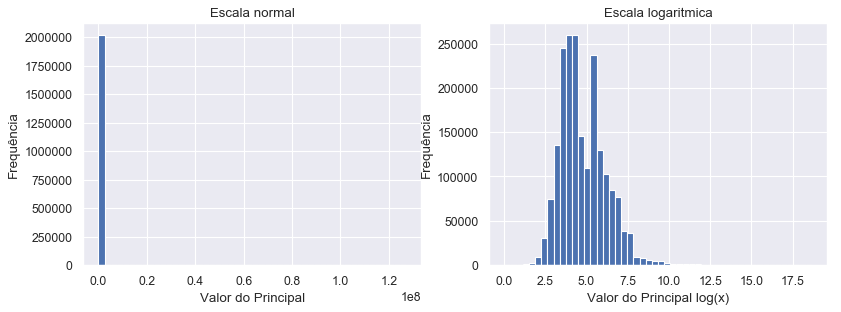

In [13]:
# Principal
plt.figure(figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1,2,1)
plt.hist(df_clean.PRINCIPAL, bins=50)
plt.title('Escala normal')
plt.xlabel('Valor do Principal')
plt.ylabel('Frequência')

# Colocando o principal na escala logaritmica pois a distribuição está muito skewd!
plt.subplot(1,2,2)
plt.hist(df_clean.PRINCIPAL.apply(lambda x: np.log(x)), bins=50)
plt.title('Escala logaritmica')
plt.xlabel('Valor do Principal log(x)')
plt.ylabel('Frequência')

plt.show()

In [14]:
bkup = df_clean.copy()
#df_clean = bkup.copy()

#### Valores de débitos de IPTU muito baixos

1. Existe um Limite mínimo de cobrança, estipulado em portaria, = 20 reais.

In [15]:
print('Valores abaixo de 20 reais: {}'.format(df_clean[df_clean.PRINCIPAL < 20].shape[0]))
df_clean = df_clean[df_clean.PRINCIPAL > 20]

Valores abaixo de 20 reais: 118275


In [16]:
# Outliers
desvio = df_clean.PRINCIPAL.std()
media = df_clean.PRINCIPAL.mean()

lim_max = media + 2 * desvio
percent_outl = (df_clean[df_clean.PRINCIPAL > lim_max].shape[0]/df_clean.shape[0]) * 100
print('Percentagem de outliers: {} %'.format(round(percent_outl,4)))

Percentagem de outliers: 0.0532 %


In [17]:
#Removendo outliers
df_clean = df_clean[df_clean.PRINCIPAL < lim_max]

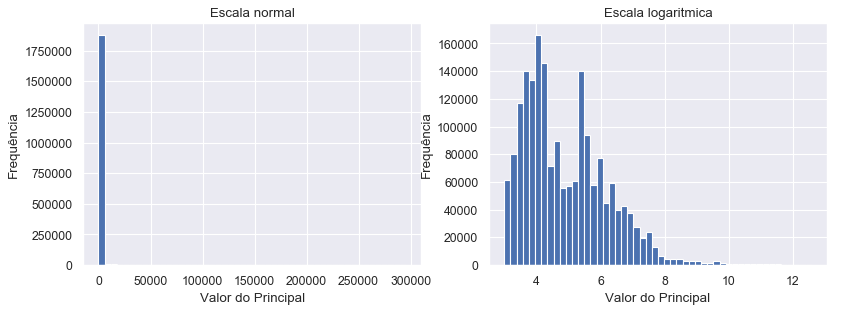

In [18]:
# Principal
plt.figure(figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1,2,1)
plt.hist(df_clean.PRINCIPAL, bins=50)
plt.title('Escala normal')
plt.xlabel('Valor do Principal')
plt.ylabel('Frequência')

# Colocando o principal na escala logaritmica pois a distribuição está muito skewd!
plt.subplot(1,2,2)
plt.hist(df_clean.PRINCIPAL.apply(lambda x: np.log(x)), bins=50)
plt.title('Escala logaritmica')
plt.xlabel('Valor do Principal')
plt.ylabel('Frequência')

plt.show()

In [19]:
# Será utilizada a escala logaritmica
df_clean['log_principal'] = df_clean.PRINCIPAL.apply(lambda x: np.log(x))

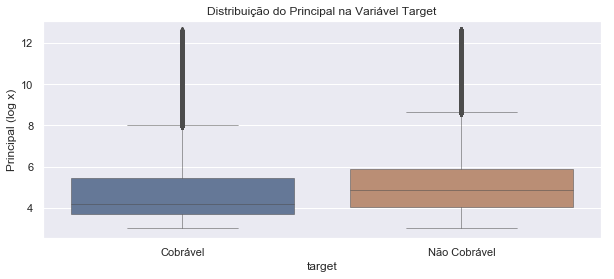

In [20]:
# Relação de log_principal com o target
sns.set(rc={'figure.figsize':(10,4)})
sns.boxplot(x='target', y='log_principal', data=df_clean, saturation=0.5, linewidth=0.5)
plt.title('Distribuição do Principal na Variável Target')
plt.ylabel('Principal (log x)')
plt.show()

#### Conclusão: Débitos de menor valor tendem a ser pagos com maior probabilidade.

### Debitos do Contribuinte

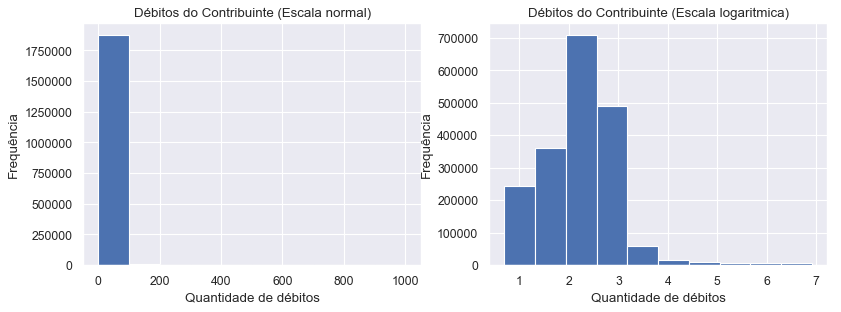

In [21]:
plt.figure(figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1,2,1)
plt.hist(df_clean.debitos_contribuinte)
plt.title('Débitos do Contribuinte (Escala normal)')
plt.xlabel('Quantidade de débitos')
plt.ylabel('Frequência')

# Colocando o principal na escala logaritmica pois a distribuição está muito skewd!
plt.subplot(1,2,2)
plt.hist(df_clean.debitos_contribuinte.apply(lambda x: np.log(x+1)))
plt.title('Débitos do Contribuinte (Escala logaritmica)')
plt.xlabel('Quantidade de débitos')
plt.ylabel('Frequência')

plt.show()

In [22]:
# Será utilizada a escala logaritmica
df_clean['log_debitos_contribuinte'] = df_clean.debitos_contribuinte.apply(lambda x: np.log(x+1))

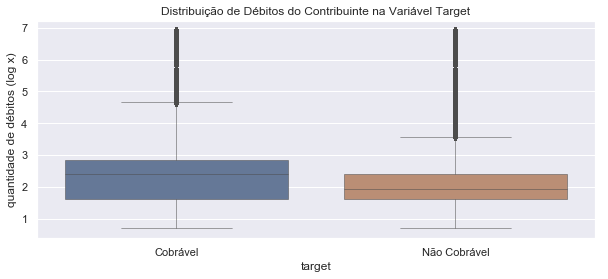

In [23]:
# Relação de log_debitos_contribuinte com o target
sns.set(rc={'figure.figsize':(10,4)})
sns.boxplot(x='target', y='log_debitos_contribuinte', data=df_clean, saturation=0.5, linewidth=0.5)
plt.title('Distribuição de Débitos do Contribuinte na Variável Target')
plt.ylabel('quantidade de débitos (log x)')
plt.show()

#### Conclusão: quanto maior a quantidade de débitos, maior a probabilidade de pagar

In [24]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900846 entries, 13 to 2739772
Data columns (total 13 columns):
COD_DEB                     category
COD_SSIS_ORIG               category
COD_TIP_ATLZ_DEB            category
DESC_TIP_CTBU_ORIG          category
DESC_TIP_DEB                category
DESC_TIP_LANC               category
MES                         category
debitos_contribuinte        float64
dias_ate_pagar              float64
target                      category
PRINCIPAL                   float64
log_principal               float64
log_debitos_contribuinte    float64
dtypes: category(8), float64(5)
memory usage: 206.8 MB


### Relação das Variáveis categóricas com a variável dependente

##### Conclusão: O valor do débito não parece ter muita influência entre o pagável e o não pagável

In [25]:
def heatmap_proportional(field, df, title='Mapa de Calor Proporcional'):
    '''
    Alterei a forma de exibição do heatmap para saber se cada um dos valores possui impacto
    na variável dependente. Como existem muitos registros concentrados em poucos valores, tive
    que fazer um proporcional para cada valor. Assim, somando todos partial_value de um valor
    o resultado será sempre df.shape[0]
    '''
    sns.set(rc={'figure.figsize':(10,6)})
    category_field = [field, 'target']
    aux = df.copy()
    aux['partial_value'] = 0
    for j in df_clean[field].unique():
        p = 1 / aux[aux[field] == j].shape[0]
        aux.loc[aux[field] == j, 'partial_value'] = p
    
    aux_prop = aux.groupby(category_field).aggregate({'partial_value':'sum'}).reset_index()
    aux_prop = aux_prop.pivot(category_field[0], category_field[1], 'partial_value')
    g = sns.heatmap(aux_prop, cmap='Blues').set_title(title)
    return g

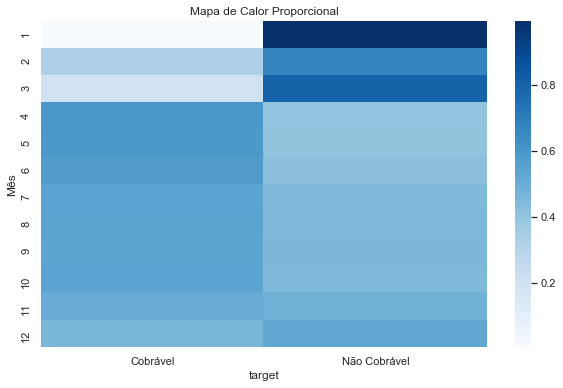

In [26]:
#Relação do target com outras variáveis
heatmap_proportional('MES', df_clean)
plt.ylabel("Mês")
plt.show()

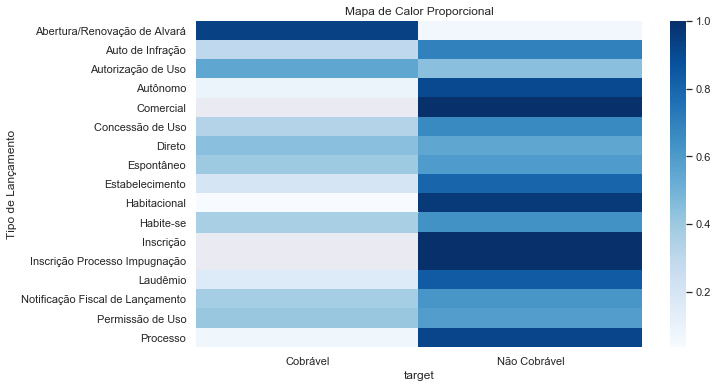

In [27]:
heatmap_proportional('DESC_TIP_LANC', df_clean)
plt.ylabel("Tipo de Lançamento")
plt.show()

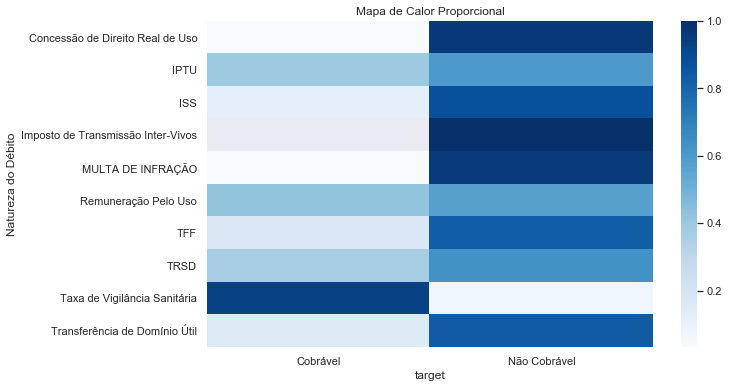

In [28]:
heatmap_proportional('DESC_TIP_DEB', df_clean)
plt.ylabel("Natureza do Débito")
plt.show()

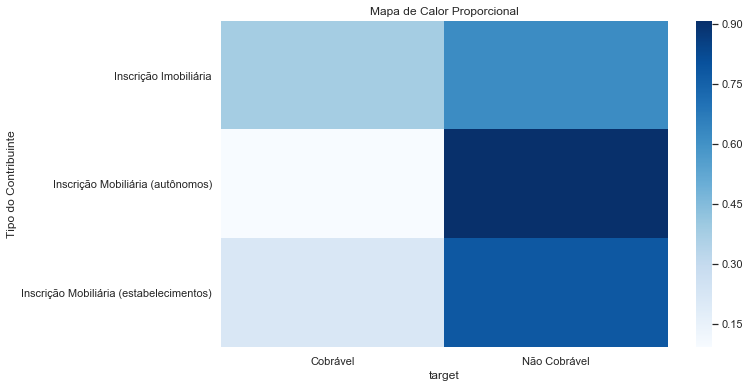

In [29]:
heatmap_proportional('DESC_TIP_CTBU_ORIG', df_clean)
plt.ylabel("Tipo do Contribuinte")
plt.show()

In [30]:
# Verificando as proporções da target
# O valor está maior do que o que consta na proposta do projeto, pois a limpeza acabou removendo registros
print('proporção de pagas / total: {:.2f} %'.format(100 * df_clean[df_clean.target == 'Cobrável'].shape[0] / df_clean.shape[0]))

proporção de pagas / total: 34.11 %


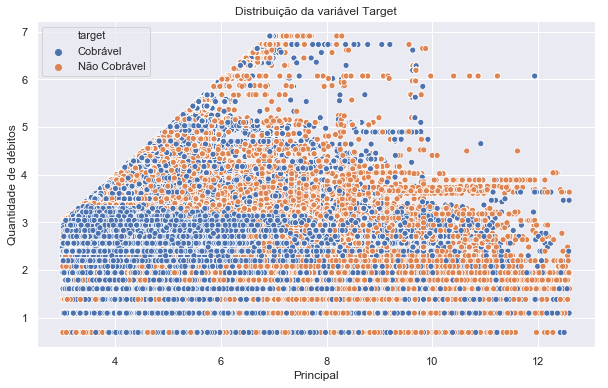

In [31]:
sns.scatterplot(x='log_principal', y='log_debitos_contribuinte', hue='target', data=df_clean)
plt.xlabel('Principal')
plt.ylabel('Quantidade de débitos')
plt.title('Distribuição da variável Target')

plt.show()

In [32]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900846 entries, 13 to 2739772
Data columns (total 13 columns):
COD_DEB                     category
COD_SSIS_ORIG               category
COD_TIP_ATLZ_DEB            category
DESC_TIP_CTBU_ORIG          category
DESC_TIP_DEB                category
DESC_TIP_LANC               category
MES                         category
debitos_contribuinte        float64
dias_ate_pagar              float64
target                      category
PRINCIPAL                   float64
log_principal               float64
log_debitos_contribuinte    float64
dtypes: category(8), float64(5)
memory usage: 206.8 MB


In [33]:
with open('../input/pickles/df_clean.pkl', 'wb') as f:
    pickle.dump(df_clean, f)

## Feature Evaluation

In [34]:
with open('../input/pickles/df_clean.pkl', 'rb') as f:
    df_ml = pickle.load(f)

df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900846 entries, 13 to 2739772
Data columns (total 13 columns):
COD_DEB                     category
COD_SSIS_ORIG               category
COD_TIP_ATLZ_DEB            category
DESC_TIP_CTBU_ORIG          category
DESC_TIP_DEB                category
DESC_TIP_LANC               category
MES                         category
debitos_contribuinte        float64
dias_ate_pagar              float64
target                      category
PRINCIPAL                   float64
log_principal               float64
log_debitos_contribuinte    float64
dtypes: category(8), float64(5)
memory usage: 126.8 MB


In [35]:
cob = [1 if x == 'Cobrável' else 0 for x in df_ml.target]
df_ml['target'] = cob
df_ml.drop(['COD_TIP_ATLZ_DEB', 'PRINCIPAL', 'COD_DEB', 'debitos_contribuinte'], axis=1, inplace=True)

# Dummies
df_ml = pd.get_dummies(df_ml)

In [36]:
scl_principal = StandardScaler()
scl_dias = StandardScaler()
scl_qtd_debitos = StandardScaler()
scl_prop_pagos = StandardScaler()

df_ml['log_principal'] = scl_principal.fit_transform(df_ml.log_principal.values.reshape(-1,1))
df_ml['dias_ate_pagar'] = scl_dias.fit_transform(df_ml.dias_ate_pagar.values.reshape(-1,1))
df_ml['log_debitos_contribuinte'] = scl_qtd_debitos.fit_transform(df_ml.log_debitos_contribuinte.values.reshape(-1,1))

X = df_ml.drop(['target'], axis=1)
y = df_ml['target'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.3, random_state=42)

In [37]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

print('Acurácia: {}'.format(accuracy_score(y_test, tree.predict(X_test))))
print('Fbeta: {}'.format(fbeta_score(y_test, tree.predict(X_test), 2)))

Acurácia: 0.997118827750441
Fbeta: 0.9954420576852686


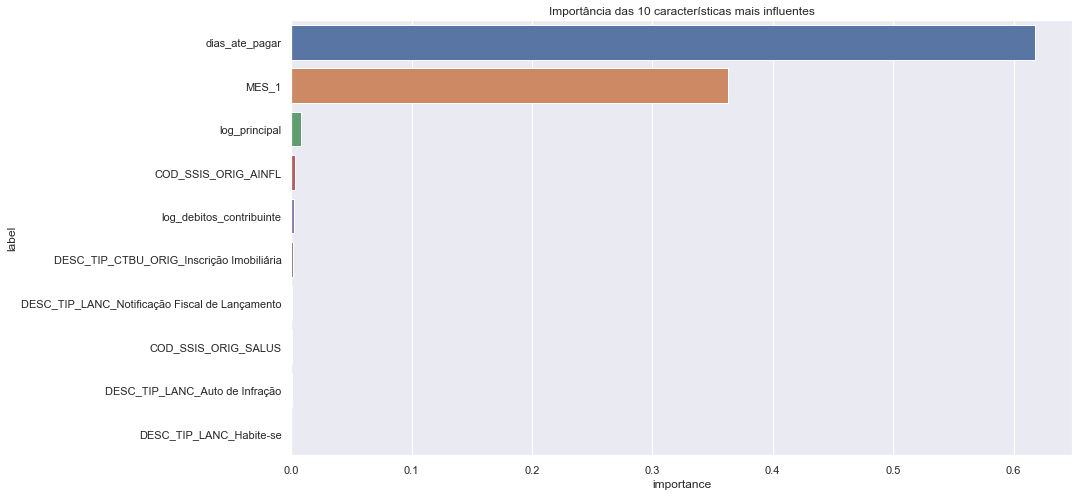

In [38]:
importances = pd.DataFrame({'label':list(X),
                            'importance':tree.feature_importances_})

top10 = importances.sort_values(['importance'], ascending=False).head(10).copy()

sns.set(rc={'figure.figsize':(14,8)})
gplot = sns.barplot(top10.importance, top10.label)
#gplot.set_xticklabels(gplot.get_xticklabels(),rotation=90)
plt.title('Importância das 10 características mais influentes')
plt.show()

#### Observação: 

1. `dias_ate_pagar` está predominando a análise. Os algoritmos irão desconsiderar as demais variáveis.
2. Como a ideia é analisar dados de diversos anos, a variável `dias_ate_pagar` terá muita variância, tornando o modelo imprevísivel
3. A variável será removida

In [39]:
#Reexaminando
X = df_ml.drop(['target', 'dias_ate_pagar'], axis=1)
y = df_ml['target'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.3, random_state=42)

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

print('Acurácia: {}'.format(accuracy_score(y_test, tree.predict(X_test))))
print('Fbeta: {}'.format(fbeta_score(y_test, tree.predict(X_test), 2)))

Acurácia: 0.7715544301311346
Fbeta: 0.6383317149183787


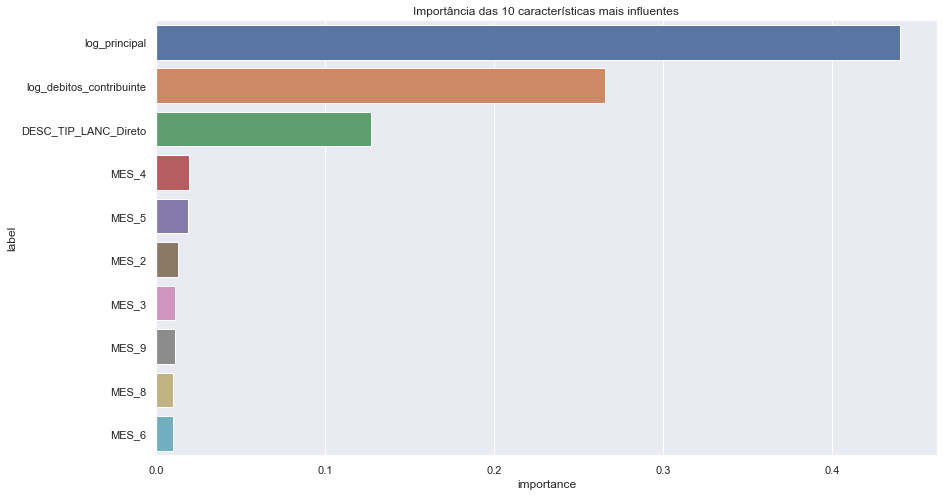

In [40]:
importances = pd.DataFrame({'label':list(X),
                            'importance':tree.feature_importances_})

top10 = importances.sort_values(['importance'], ascending=False).head(10).copy()

sns.set(rc={'figure.figsize':(14,8)})
gplot = sns.barplot(top10.importance, top10.label)
#gplot.set_xticklabels(gplot.get_xticklabels(),rotation=90)
plt.title('Importância das 10 características mais influentes')
plt.show()

#### Observação: 

1. `perc_debitos_pagos`está dominando a análise. A acurácia da árvore de decisão é alta, mas não o suficiente para indicar que esta variável está dominando totalmente as outras. Devido a isso a variável será preservada.

### Conclusão

1. O modelo ainda é dominado por uma variável, porém esta é muito importante para análise;
2. Também é bom observar que a importância das outras variáveis foi maior

#### Salvando X e y e o StandardScaler

In [41]:
with open('../input/pickles/X_main.pkl', 'wb') as f:
    pickle.dump(X, f)

with open('../input/pickles/y_main.pkl', 'wb') as f:
    pickle.dump(y, f)
    
with open('../input/pickles/scl_principal.pkl', 'wb') as f:
    pickle.dump(scl_principal, f)
    
with open('../input/pickles/scl_qtd_debitos.pkl', 'wb') as f:
    pickle.dump(scl_qtd_debitos, f)

with open('../input/pickles/perc_debitos_pagos.pkl', 'wb') as f:
    pickle.dump(scl_prop_pagos, f)